## MNIST Training and Prediction with SageMaker Chainer

[MNIST](http://yann.lecun.com/exdb/mnist/), the "Hello World" of machine learning, is a popular dataset for handwritten digit classification. It consists of 70,000 28x28 grayscale images labeled in 10 digit classes (0 to 9). This tutorial will show how to train on MNIST using SageMaker Chainer in [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk).

In [1]:
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

## Download MNIST datasets

We can use Chainer's built-in get_mnist() method to download, import and preprocess the MNIST dataset.

In [2]:
import os

import chainer

try:
    os.makedirs('data/train')
    os.makedirs('data/test')
except FileExistsError:
    print('Directories already exist!')

train, test = chainer.datasets.get_mnist()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Directories already exist!


## Parse, save, and upload the data

We save our data, then use sagemaker_session.upload_data to upload the data to an S3 location used for training. The return value identifies the S3 path to the uploaded data.

In [3]:
import numpy as np

train_images = np.array([data[0] for data in train])
train_labels = np.array([data[1] for data in train])
test_images = np.array([data[0] for data in test])
test_labels = np.array([data[1] for data in test])

np.savez('data/train/train.npz', images=train_images, labels=train_labels)
np.savez('data/test/test.npz', images=test_images, labels=test_labels)

train_input = sagemaker_session.upload_data(path=os.path.join('data', 'train'), key_prefix='notebook/chainer/mnist')
test_input = sagemaker_session.upload_data(path=os.path.join('data', 'test'), key_prefix='notebook/chainer/mnist')

## Prepare user script for training and prediction

We need to provide a user script that can run on the SageMaker platform. The script is essentially the same as one you would write for local training, except that a function `train` that returns a trained `chainer.Chain` model is required. By default, this model is saved to disk as an npz file named `model.npz`.
For prediciton, this script also requires a function `model_fn` that loads the `chainer.Chain` saved from training. When SageMaker calls your `train` and `model_fn` functions, it will pass in arguments that describe the training environment.
You could find a detailed instruction for writing a user script in [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk).

The below user script used in our tutorial is adapted from [chainer mnist example](https://github.com/chainer/chainer/blob/master/examples/mnist/train_mnist_data_parallel.py)

In [4]:
!cat 'chainer_mnist_single_machine.py'

#  Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#  
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#  
#      http://www.apache.org/licenses/LICENSE-2.0
#  
#  or in the "license" file accompanying this file. This file is distributed 
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either 
#  express or implied. See the License for the specific language governing 
#  permissions and limitations under the License.

from __future__ import print_function

import os

import numpy as np
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training, serializers
from chainer.training import extensions
from chainer.datasets import tuple_dataset


# Define the network to train MNIST
class MLP(chainer.Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
 

## Create SageMaker chainer estimator

To train MNIST, let's construct a `sagemaker.chainer.estimator.Chainer` estimator. A quick explanation for some configurable arguments here:

`entry_point`: The user script SageMaker runs for training and prediction.

`train_instance_count`: The number of SageMaker instances for training. Since we only do single machine training in this tutorial, it should be 1.

`train_instance_type`: The type of SageMaker instances for training. We pass the string 'local' here to enable the [local mode](https://github.com/aws/sagemaker-python-sdk#local-mode) for training in the local environment. If you want to train on a remote instance, specify a SageMaker ML instance type here accordingly. See [Amazon SageMaker ML Instance Types](https://aws.amazon.com/sagemaker/pricing/instance-types/)

`hyperparameters`: The hyper-parameters defined in the user script. In this tutorial, `epochs`, `batch_size` and `frequency` can be configured and passed.

In [5]:
from sagemaker.chainer.estimator import Chainer

chainer_estimator = Chainer(entry_point='chainer_mnist_single_machine.py', role=role,
                            train_instance_count=1, train_instance_type='local',
                            hyperparameters={'epochs': 16, 'batch_size': 128})

## Train on MNIST data in S3

After we've constructed our Chainer object, we can fit it using the MNIST data we uploaded to S3. SageMaker makes sure our data is available in the local filesystem, so our user script can simply read the data from disk.

In [6]:
chainer_estimator.fit({'train': train_input, 'test': test_input})

INFO:sagemaker:Creating training-job with name: sagemaker-chainer-2018-05-08-00-18-06-662


Attaching to tmpkva374cb_algo-1-PM0PE_1
algo-1-PM0PE_1  | 2018-05-08 00:18:36,329 INFO - root - running container entrypoint
algo-1-PM0PE_1  | 2018-05-08 00:18:36,330 INFO - root - starting train task
algo-1-PM0PE_1  | 2018-05-08 00:18:36,333 INFO - container_support.app - started training: {'train_fn': <function train at 0x7f2e38f3e400>}
algo-1-PM0PE_1  | Downloading s3://sagemaker-us-west-2-360423169059/sagemaker-chainer-2018-05-08-00-18-06-662/source/sourcedir.tar.gz to /tmp/script.tar.gz
algo-1-PM0PE_1  | 2018-05-08 00:18:36,357 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.169.254
algo-1-PM0PE_1  | 2018-05-08 00:18:36,362 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTP connection (1): 169.254.169.254
algo-1-PM0PE_1  | 2018-05-08 00:18:36,418 INFO - botocore.vendored.requests.packages.urllib3.connectionpool - Starting new HTTPS connection (1): sagemaker-us-west-2-360423169059.s3.am

algo-1-PM0PE_1  |      total [###########.......................................] 22.67%
algo-1-PM0PE_1  | this epoch [###############################...................] 62.67%
algo-1-PM0PE_1  |       1700 iter, 3 epoch / 16 epochs
algo-1-PM0PE_1  |     27.122 iters/sec. Estimated time to finish: 0:03:33.845308.
algo-1-PM0PE_1  |      total [############......................................] 24.00%
algo-1-PM0PE_1  | this epoch [#########################################.........] 84.00%
algo-1-PM0PE_1  |       1800 iter, 3 epoch / 16 epochs
algo-1-PM0PE_1  |     27.179 iters/sec. Estimated time to finish: 0:03:29.718424.
algo-1-PM0PE_1  | 4           0.0342841   0.067431              0.988815       0.979134                  69.7503       
algo-1-PM0PE_1  |      total [############......................................] 25.33%
algo-1-PM0PE_1  | this epoch [##................................................]  5.33%
algo-1-PM0PE_1  |       1900 iter, 4 epoch / 16 epochs
algo-1-PM0PE_1  |

algo-1-PM0PE_1  |      total [##########################........................] 52.00%
algo-1-PM0PE_1  | this epoch [################..................................] 32.00%
algo-1-PM0PE_1  |       3900 iter, 8 epoch / 16 epochs
algo-1-PM0PE_1  |     26.311 iters/sec. Estimated time to finish: 0:02:16.825547.
algo-1-PM0PE_1  |      total [##########################........................] 53.33%
algo-1-PM0PE_1  | this epoch [##########################........................] 53.33%
algo-1-PM0PE_1  |       4000 iter, 8 epoch / 16 epochs
algo-1-PM0PE_1  |     26.315 iters/sec. Estimated time to finish: 0:02:13.002676.
algo-1-PM0PE_1  |      total [###########################.......................] 54.67%
algo-1-PM0PE_1  | this epoch [#####################################.............] 74.67%
algo-1-PM0PE_1  |       4100 iter, 8 epoch / 16 epochs
algo-1-PM0PE_1  |     26.316 iters/sec. Estimated time to finish: 0:02:09.198996.
algo-1-PM0PE_1  |      total [#########################

algo-1-PM0PE_1  | 13          0.010588    0.0915087             0.996635       0.981705                  238.681       
algo-1-PM0PE_1  |      total [########################################..........] 81.33%
algo-1-PM0PE_1  | this epoch [..................................................]  1.33%
algo-1-PM0PE_1  |       6100 iter, 13 epoch / 16 epochs
algo-1-PM0PE_1  |     25.491 iters/sec. Estimated time to finish: 0:00:54.921864.
algo-1-PM0PE_1  |      total [#########################################.........] 82.67%
algo-1-PM0PE_1  | this epoch [###########.......................................] 22.67%
algo-1-PM0PE_1  |       6200 iter, 13 epoch / 16 epochs
algo-1-PM0PE_1  |     25.488 iters/sec. Estimated time to finish: 0:00:51.004996.
algo-1-PM0PE_1  |      total [##########################################........] 84.00%
algo-1-PM0PE_1  | this epoch [#####################.............................] 44.00%
algo-1-PM0PE_1  |       6300 iter, 13 epoch / 16 epochs
algo-1-PM0PE_1

algo-1-PM0PE_1  | tmpkva374cb_algo-1-PM0PE_1 exited with code 0
Aborting on container exit...
===== Job Complete =====


Our user script writes various artifacts, such as plots, to a directory `output_data_dir`, the contents of which SageMaker uploads to S3. Now we download and extract these artifacts.

In [31]:
import shutil

try:
    os.makedirs('output/single_machine_mnist')
except FileExistsError:
    print('Directory already exist!')

chainer_training_job = chainer_estimator.latest_training_job.name

desc = chainer_estimator.sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=chainer_training_job)
output_data = desc['ModelArtifacts']['S3ModelArtifacts'].replace('s3_model_artifacts', '')
status = os.system('cp {}algo*/output/data/*.png output/single_machine_mnist'.format(output_data))

These plots show the accuracy and loss over epochs:

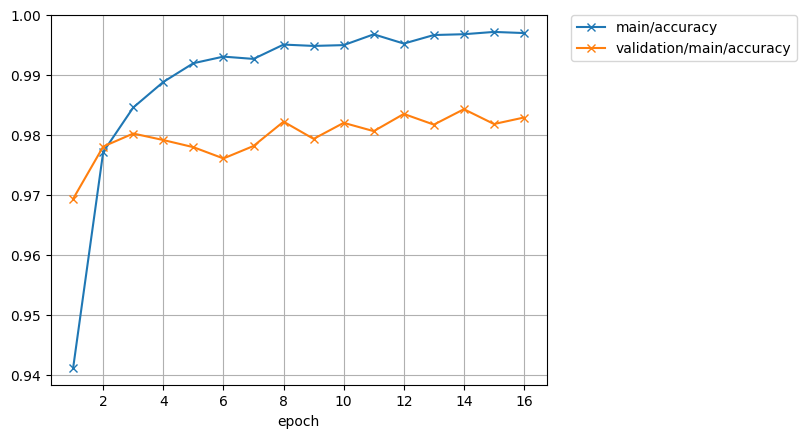

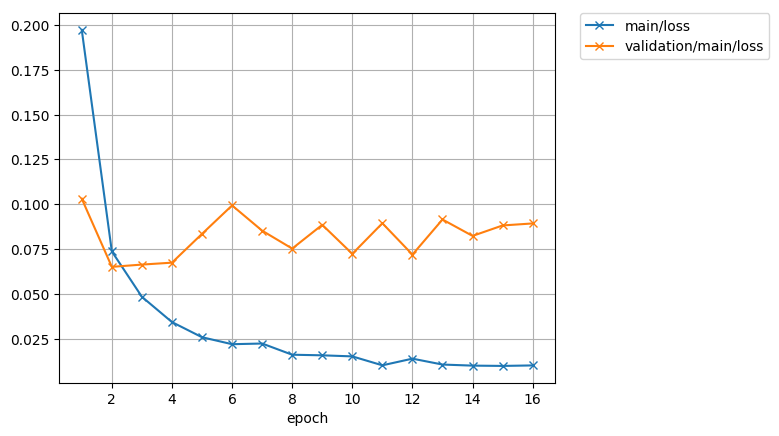

In [32]:
from IPython.display import Image
from IPython.display import display

accuracy_graph = Image(filename = "output/single_machine_mnist/accuracy.png", width=800, height=800)
loss_graph = Image(filename = "output/single_machine_mnist/loss.png", width=800, height=800)

display(accuracy_graph, loss_graph)

## Deploy model to endpoint

After training, we deploy the model to an endpoint using the Chainer estimator object. Here we also specify instance_type to be `local` to deploy the model to the local environment. If you want to deploy the model to a remote instance, specify a SageMaker ML instance type here accordingly.

In [8]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='local')

INFO:sagemaker:Creating model with name: sagemaker-chainer-2018-05-08-00-18-06-662
INFO:sagemaker:Creating endpoint with name sagemaker-chainer-2018-05-08-00-18-06-662


!

## Predict Hand-Written Digit

We can now use this predictor to classify hand-written digits. Drawing into the image box loads the pixel data into a variable named 'data' in this notebook, which we can then pass to the Chainer predictor.

In [33]:
from IPython.display import HTML
HTML(open("input.html").read())

Now let's see if your writing can be recognized!

In [46]:
image = np.array(data, dtype=np.float32)
prediction = predictor.predict(image)
predicted_label = prediction.argmax(axis=1)[0]
print('What you wrote is: {}'.format(predicted_label))

What you wrote is: 7


We can also get some random test images in MNIST.

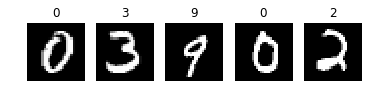

In [52]:
import random

import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images, labels = test_images[indices], test_labels[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

Now let's see if we can make correct predictions.

In [53]:
prediction = predictor.predict(images)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

The predicted labels are: [0 3 9 0 2]


## Clean resources

After you have finished with this example, remember to delete the prediction endpoint to release the instance associated with it and remove the data and outputs saved locally.

In [54]:
chainer_estimator.delete_endpoint()
shutil.rmtree('data')
shutil.rmtree('output')

INFO:sagemaker:Deleting endpoint with name: sagemaker-chainer-2018-05-08-00-18-06-662
